In this notebook we explore the content of example [larcv](https://github.com/DeepLearnPhysics/larcv2) data file. We assume you already set up [larcv](https://github.com/DeepLearnPhysics/larcv2) environment and cloned [larcv-tutorial](https://github.com/DeepLearnPhysics/larcv-tutorial) repository. If not, checkout our [installation tutorial](https://deeplearnphysics.org/Blog/tutorials/tutorial-01.html).

In [2]:
from __future__ import print_function
import ROOT
from larcv import larcv
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

## Opening a file interactively
We use example files that come with [larcv-tutorial](https://github.com/DeepLearnPhysics/larcv-tutorial). They should be residing at the top directory of the repository and called `proton.root` and `electron.root`. You will have to modify `REPOSITORY_DIR` value in the next cell for your own case!

In [3]:
REPOSITORY_DIR='../'
_files = [REPOSITORY_DIR + f for f in ['proton.root','electron.root']]

Let's start by opening the bare root file:

In [4]:
_f = ROOT.TFile(_files[0])
_f.ls()

TFile**		../proton.root	
 TFile*		../proton.root	
  KEY: TTree	particle_mctruth_tree;1	mctruth tree
  KEY: TTree	image2d_data_tree;1	data tree


## Understanding the contents
In this file, larcv data is stored in the form of [ROOT TTree](https://root.cern.ch/doc/master/classTTree.html). Each TTree holds one data instance, and each entry corresponds to an individual entry or what we call an *event*. TTrees in the same file are *entry-aligned*. In this file, you see 2 TTrees: *particle_mctruth_tree* and *image2d_data_tree*. Because they are entry-aligned, *X*-th entry of two TTrees correspond to the same event (but storing different data information).

### What *TTree* name tells us?
TTree name string is composed of 3 separate sub-strings that is useful to users and software tools. The separation of 3 sub-strings is by the first and the last "underscore", or "\_". The first sub-string is a unique identifier for a certain data product type. The second sub-string is a unique identifier for a certain data product instance. Finally the last string should be just "tree". For example, "image2d\_data\_tree" carries a data product type identified by "image2d" (`larcv::Image2D` in C++ source code) with its particular instance by the name "data".

Let's check out "image2d\_data\_tree": this holds a simple 2D image data. We use a handy [ROOT TChain](https://root.cern.ch/doc/master/classTChain.html) with [pyroot](https://root.cern.ch/pyroot) interface:

In [5]:
image_chain = ROOT.TChain("image2d_data_tree")

for _file in _files: image_chain.AddFile(_file)
    
print('Found', image_chain.GetEntries(), 'entries!')

Found 20 entries!


So we found 20 total entries from 2 input files!

## Accessing a particular event (entry)
Here's how you can access a particular `entry` and grab the data instance:

In [6]:
entry = 0
image_chain.GetEntry(entry)
# actual data product is accessible by an attribute name = ttree name replaced "tree" with "branch"
entry_data = image_chain.image2d_data_branch
print('Data type:', entry_data)

Data type: <ROOT.larcv::EventImage2D object at 0x7fa2907aea10>


`entry_data` is a C++ class `larcv::EventImage2D` exposed to python interpreter. For full details, you can look at larcv source code at `larcv/core/DataFormat/EventImage2D.h`. Each `larcv::EventImage2D` consists of one or more 2D images. How many? let's check:

In [7]:
image2d_array = entry_data.as_vector()
print('Type of image2d_array:', type(image2d_array))
print('Number of images:', image2d_array.size())

Type of image2d_array: <class '__main__.vector<larcv::Image2D>'>
Number of images: 3


So it says the type of `image2d_array` is `std::vector<larcv::Image2D>` and we have 3 of them!

## Visualizing `larcv::Image2D` with matplotlib
Let's see how they (2D images in entry_data) look like:

Image index 0
image_numpy has type <type 'numpy.ndarray'>
Image dimensions are (256, 256)


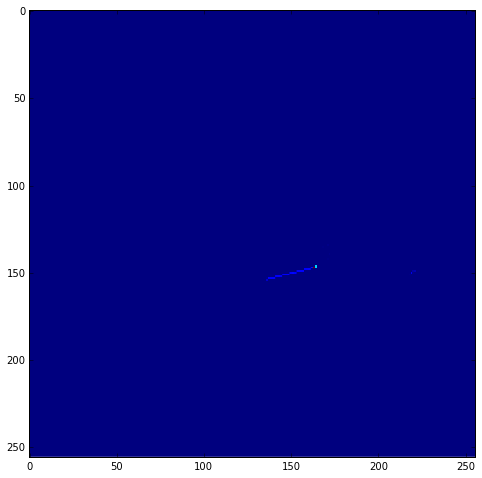

Image index 1
image_numpy has type <type 'numpy.ndarray'>
Image dimensions are (256, 256)


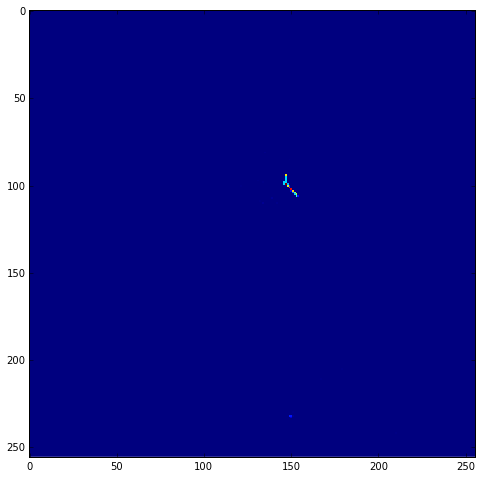

Image index 2
image_numpy has type <type 'numpy.ndarray'>
Image dimensions are (256, 256)


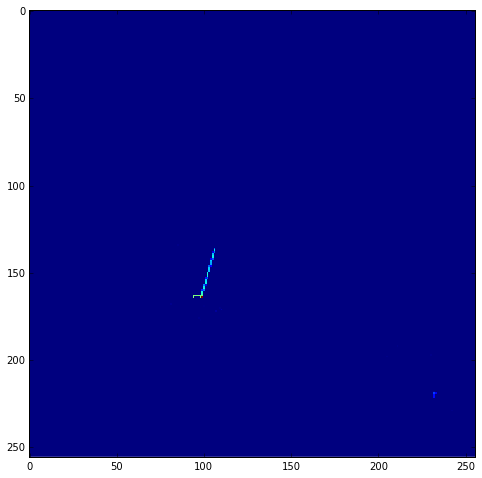

In [8]:
for index, image in enumerate(image2d_array):
    # Note here that std::vectors in pyroot are iterable
    # larcv has a helper function to convert std::vector to numpy array, so we can use that:
    image_numpy = larcv.as_ndarray(image)
    print("Image index", index)
    print("image_numpy has type {}".format(type(image_numpy)))
    print("Image dimensions are {}".format(image_numpy.shape))
    #Show the image with imshow:
    fig = plt.figure(figsize=(8,8))
    plt.imshow(image_numpy, interpolation='none',cmap='jet')
    plt.show()

## Particle: simulation information for _labels_
So what are those images we just printed? They are 2D projections (`xy`, `yz`, and `zx`) of 3D energy deposition profile of a particle. That's why there are three 2D images. But what particle? at what energy/momentum? These images are generated using a particle simulation in LAr. Because it is from simulation, we know _every_ _single_ _detail_ of what is going on. Much of simulation information is stored in a data product `larcv::EventParticle`, which is the other TTree you saw in the file.

Let's load it up.

In [9]:
# Create TChain & load files
particle_chain = ROOT.TChain("particle_mctruth_tree")
for _file in _files: particle_chain.AddFile(_file)
print('Found',particle_chain.GetEntries(),'entries!')

# Get the same entry (event)
particle_chain.GetEntry(entry)
entry_data = particle_chain.particle_mctruth_branch
print('Data type:', entry_data)

# Get an array of "larcv::Particle"
particle_array = entry_data.as_vector()
print('Type of particle_array:', type(particle_array))
print('Number of particles:', particle_array.size())
print()

# Print out particle information
for index, particle in enumerate(particle_array):
    print("Particle index", index)
    print("Particle PDG code", particle.pdg_code())
    print("Particle initial energy", int(particle.energy_init() * 1000),'[MeV]')



Found 20 entries!
Data type: <ROOT.larcv::EventParticle object at 0x7fa2928b0dd0>
Type of particle_array: <class '__main__.vector<larcv::Particle>'>
Number of particles: 1

Particle index 0
Particle PDG code 2212
Particle initial energy 1138 [MeV]


... so we can see that the images we looked at are from a simulated proton with total energy at about 1.1GeV. We know that the list of files we loaded contain electrons. Let's search for it!

In [10]:
for entry in xrange(particle_chain.GetEntries()):
    particle_chain.GetEntry(entry)
    entry_data = particle_chain.particle_mctruth_branch
    for particle in entry_data.as_vector(): print('Entry',entry,'Particle PDG code',particle.pdg_code())

Entry 0 Particle PDG code 2212
Entry 1 Particle PDG code 2212
Entry 2 Particle PDG code 2212
Entry 3 Particle PDG code 2212
Entry 4 Particle PDG code 2212
Entry 5 Particle PDG code 2212
Entry 6 Particle PDG code 2212
Entry 7 Particle PDG code 2212
Entry 8 Particle PDG code 2212
Entry 9 Particle PDG code 2212
Entry 10 Particle PDG code 11
Entry 11 Particle PDG code 11
Entry 12 Particle PDG code 11
Entry 13 Particle PDG code 11
Entry 14 Particle PDG code 11
Entry 15 Particle PDG code 11
Entry 16 Particle PDG code 11
Entry 17 Particle PDG code 11
Entry 18 Particle PDG code 11
Entry 19 Particle PDG code 11


Great, so entry 10 and onwards contain PDG code 11, which is electron. Let's print images for entry 10!

Image index 0
image_numpy has type <type 'numpy.ndarray'>
Image dimensions are (256, 256)


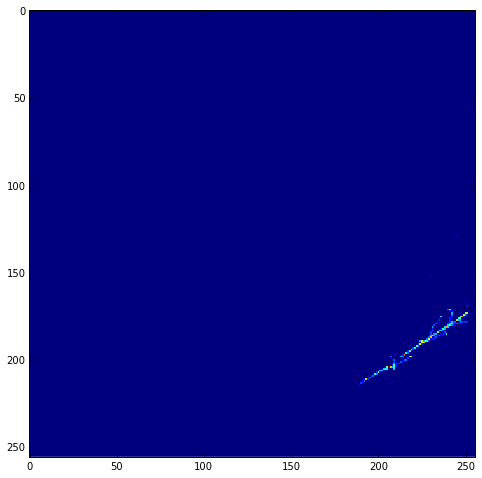

Image index 1
image_numpy has type <type 'numpy.ndarray'>
Image dimensions are (256, 256)


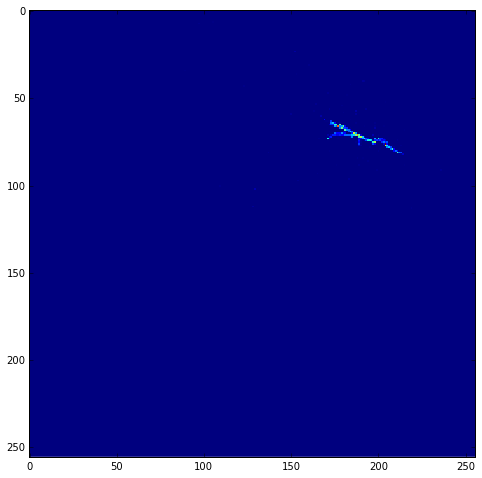

Image index 2
image_numpy has type <type 'numpy.ndarray'>
Image dimensions are (256, 256)


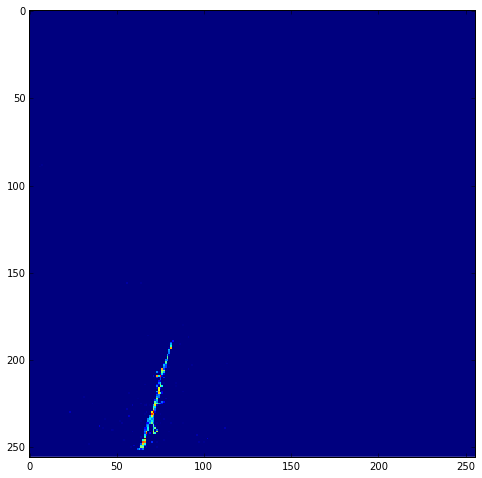

In [11]:
entry = 10
image_chain.GetEntry(entry)
image2d_array = image_chain.image2d_data_branch.as_vector()

for index, image in enumerate(image2d_array):
    image_numpy = larcv.as_ndarray(image)
    print("Image index", index)
    print("image_numpy has type {}".format(type(image_numpy)))
    print("Image dimensions are {}".format(image_numpy.shape))
    fig = plt.figure(figsize=(8,8))
    plt.imshow(image_numpy, interpolation='none',cmap='jet')
    plt.show()

... indeed it's an electron!  We can (just for fun, here) zoom in on the region with the highest charge (take just one projection for this):

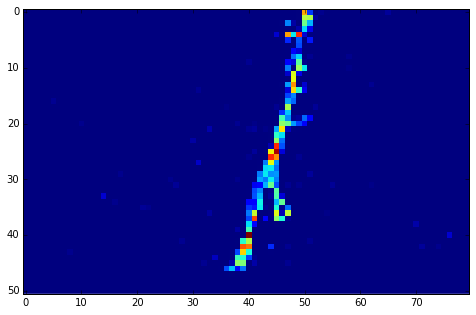

In [12]:
projection2 = larcv.as_ndarray(image2d_array[2])
x, y = numpy.unravel_index(projection2.argmax(), projection2.shape)
crop_size=40
zoom_image = projection2[x-crop_size:x+crop_size, y-crop_size:y+crop_size]
fig = plt.figure(figsize=(8,8))
plt.imshow(zoom_image, interpolation='none', cmap='jet')
plt.show()

In this notebook, we saw we could open raw larcv root files and extract images and truth information.  In principle, this is enough for single particle training, but we can do better if we take advantage of everything larcv offers.